In [1]:
import pandas as pd
from scipy.stats import norm
import statsmodels.stats.meta_analysis as meta
import numpy as np
from statsmodels.stats.multitest import multipletests
import re

import os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
aou_df = pd.read_csv("../data/pgs_interaction/monogenic_pgs_int_aou.csv.gz")
ukb_df = pd.read_csv("../data/pgs_interaction/monogenic_pgs_int_ukb.csv.gz")

In [3]:
meta_df = aou_df.merge(ukb_df, on=["ID", "gene"], suffixes=("_aou", "_ukb"))

In [4]:
def get_meta_stats_helper(ser, ancestry):
    effect_sizes = np.array([ser[f"coef_{a}"] for a in ancestry])
    variances = np.array([(ser[f"se_{a}"]**2)*ser[f"obs_{a}"] for a in ancestry])
    summary = meta.combine_effects(effect_sizes, variances, method_re="iterated")
    summary_df = summary.summary_frame()
    combined_effect_size = summary_df.loc["random effect wls", "eff"]
    combined_se = summary_df.loc["random effect wls", "sd_eff"]
    ci_low = summary_df.loc["random effect wls", "ci_low"]
    ci_high = summary_df.loc["random effect wls", "ci_upp"]
    # Calculate the Z-score
    z_score = combined_effect_size / combined_se
    # Calculate the two-tailed p-value
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return combined_effect_size, combined_se, ci_low, ci_high, z_score, p_value


def get_meta_stats(ser):
    cohorts =  ["aou", "ukb"]
    es, se, ci_low, ci_high, z_score, p_value = get_meta_stats_helper(ser, cohorts)
    return pd.Series(
        {"ID": ser.ID, "gene": ser.gene, "beta": es, "se": se, "ci_low": ci_low, "ci_high": ci_high, "z_score":z_score, "p_value": p_value,
        })

In [5]:
RERUN=False
if RERUN:
    meta_pgs_df = meta_df.apply(get_meta_stats, axis=1)
    meta_pgs_df.to_excel("../data/pgs_interaction/monogenic_pgs_int_meta.xlsx", index=False)

In [6]:
monogenic_meta_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")
monogenic_meta_pgs_df = pd.read_excel("../data/pgs_interaction/monogenic_pgs_int_meta.xlsx")

In [7]:
monogenic_meta_pgs_df["bmi_beta"] = monogenic_meta_pgs_df.ID.map(monogenic_meta_df.set_index("ID").beta.to_dict())

In [8]:
def get_bmi_pgs_cat(ser):
    if ser.bmi_beta>0:
        gene_type="risk"
    else:
        gene_type="protective"
    
    if ser.beta>0:
        interaction_type="risk"
    else:
        interaction_type="protective"
    
    if ser.p_value<5e-2:
        significance="significant"
    else:
        significance="nonsignificant"
    
    return "_".join([gene_type, interaction_type, significance])

monogenic_meta_pgs_df["category"] = monogenic_meta_pgs_df.apply(get_bmi_pgs_cat, axis=1)



def highest_effect(x):
    x=list(x)
    return x[np.argmax(np.abs(x))]

def p_value_formatter(pval):
    if pval==0:
        pval = "0"
    else:
        pval = f"{pval:.2e}"
        pval = pval.replace("e", "x10")
        # base, exponent = pval.split("^")
        # pval = f"{base}$^{{{exponent}}}$"
        # #pval = f"{base}$^{exponent}$"
    return pval

plot_pgs_df = monogenic_meta_pgs_df.loc[monogenic_meta_pgs_df.category.str.endswith("_significant")]
plot_pgs_df = plot_pgs_df.drop(columns=["ID"])
plot_pgs_df = plot_pgs_df.groupby(["gene", "category"]).agg(highest_effect).reset_index()
plot_pgs_df["formatted_bmi_beta"] = plot_pgs_df.bmi_beta.apply(lambda x: f"{x:.2f}")
plot_pgs_df["formatted_beta"] = plot_pgs_df.beta.apply(lambda x: f"{x:.2f}")
plot_pgs_df["formatted_ci"] = "(" + plot_pgs_df.ci_low.apply(lambda x: f"{x:.2f}") + ", " + plot_pgs_df.ci_high.apply(lambda x: f"{x:.2f}") + ")"
plot_pgs_df["formatted_se"] = plot_pgs_df.se.apply(lambda x: f"{x:.2f}")
plot_pgs_df["formatted_z_score"] = plot_pgs_df.z_score.apply(lambda x: f"{x:.2f}")
plot_pgs_df["formatted_p_value"] = plot_pgs_df.p_value.apply(p_value_formatter)
plot_pgs_df["Beta (95% CI)"] = plot_pgs_df.apply(lambda ser: f"{ser.formatted_beta} {ser.formatted_ci}", axis=1)

In [9]:
len(plot_pgs_df.loc[
    (plot_pgs_df.category=="risk_risk_significant")&
    (plot_pgs_df.p_value<0.05)
    ]), len(plot_pgs_df.loc[
    (plot_pgs_df.category=="protective_protective_significant")&
    (plot_pgs_df.p_value<0.05)
    ])

(14, 23)

In [10]:
selected_genes = [
    "VIRMA", "ZNF627", "PI4KB", "AQP3", "TSPAN4", "SCFD1", "BAIAP3", "NALCN", "FARP2", "PML",
    "SH3GL2", "CTBP2", "MIPEP", "APMAP",
    "ZG16", "PAM", "UBR2",
    "TALDO1", "TNK2", "DCP1B", "ICE1", "SNAP47", "C1orf174", "FAM171A2", "BSN"
]

In [11]:
plot_pgs_df = plot_pgs_df.loc[plot_pgs_df.gene.isin(selected_genes)]

In [12]:
plot_pgs_df["abs_beta"] = plot_pgs_df.beta.abs()

In [13]:
plot_pgs_df.head(2)

,gene,category,beta,se,ci_low,ci_high,z_score,p_value,bmi_beta,formatted_bmi_beta,formatted_beta,formatted_ci,formatted_se,formatted_z_score,formatted_p_value,Beta (95% CI),abs_beta
1,APMAP,protective_risk_significant,0.636534,0.033032,0.571792,0.701276,19.270105,0.0,-0.494177,-0.49,0.64,"(0.57, 0.70)",0.03,19.27,0,"0.64 (0.57, 0.70)",0.636534
2,AQP3,protective_protective_significant,-0.316482,0.016504,-0.348829,-0.284135,-19.176259,0.0,-2.055961,-2.06,-0.32,"(-0.35, -0.28)",0.02,-19.18,0,"-0.32 (-0.35, -0.28)",0.316482


In [18]:
def create_forestplot(
    df, studies, category_order, 
    labels_col, category_col, effect_sizes_col, ci_low_col, ci_high_col,
    stats_cols, sort_col
):

    # Create a figure with two axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5, 6.8), gridspec_kw={'width_ratios': [1, 1.5]},sharey=True)

    # Horizontal line at 0 for the null effect
    ax.axvline(x=0, color='k', linestyle='--')
    
    df["ci_low_error"] = df[effect_sizes_col] - df[ci_low_col]
    df["ci_high_error"] =  df[ci_high_col] - df[effect_sizes_col]
    
    ### main plot ###
    # Plotting the effect sizes with different markers per category
    last_offset = 0
    for j,category in enumerate(category_order):
        cat_df = df.loc[df[category_col]==category]
        cat_df = cat_df.sort_values(sort_col, ascending=False)
        ax.text(min(df[ci_low_col])-2, last_offset, category, ha='center', va='center', fontweight='normal')
        last_offset +=1
        for i, study in enumerate(cat_df[labels_col].unique()):
            effect_size = cat_df.loc[(cat_df[labels_col]==study), effect_sizes_col].values[0]
            ci_low_error = cat_df.loc[(cat_df[labels_col]==study), "ci_low_error"].values[0]
            ci_high_error = cat_df.loc[(cat_df[labels_col]==study), "ci_high_error"].values[0]
            errors = np.array([ci_low_error, ci_high_error]).reshape(2, 1)
            # Plot each category with a different marker
            ax.errorbar(effect_size, i+last_offset, xerr=[[ci_low_error], [ci_high_error]], fmt="o", color="k", capsize=5)

            # Place the study name above the group of categories
            ax.text(min(df[ci_low_col])-2, i+last_offset, study, ha='center', va='center', fontweight='normal', style="italic")
        last_offset = i+last_offset+1
        
    ax.text(min(df[ci_low_col])-2, -1, "Genes", ha='center', va='center', fontweight='normal')
    
    # Invert the y-axis so the studies are from top to bottom
    ax.invert_yaxis()

    # Customize the left axis: remove yticks but keep the ytick labels for study names
    ax.set_yticks([])
    ax.tick_params(axis='y', which='both', length=0) 


    # Labels for axes
    ax.set_xlabel('Effect Size')
    # ax.set_title('Forest Plot')
    # Remove top, right, and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    last_offset = 0
    for j,category in enumerate(category_order):
        cat_df = df.loc[df[category_col]==category]
        cat_df = cat_df.sort_values(sort_col, ascending=False)
        last_offset +=1
        for i, study in enumerate(cat_df[labels_col].unique()):
            for s, st_col in enumerate(stats_cols):
                stat = cat_df.loc[(cat_df[labels_col]==study), st_col].values[0]
                ax2.text(0.1+0.5*s,i+last_offset, f"{stat}", va='center', ha="center")
                ax2.text(0.1+0.5*s, -1, f"{st_col.lstrip('formatted_')}", va='center', ha="center")
        last_offset = i+last_offset+1
    # Remove the spines and ticks for ax2
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    # ax2.set_title('Statistics')

    plt.tight_layout()
    return fig


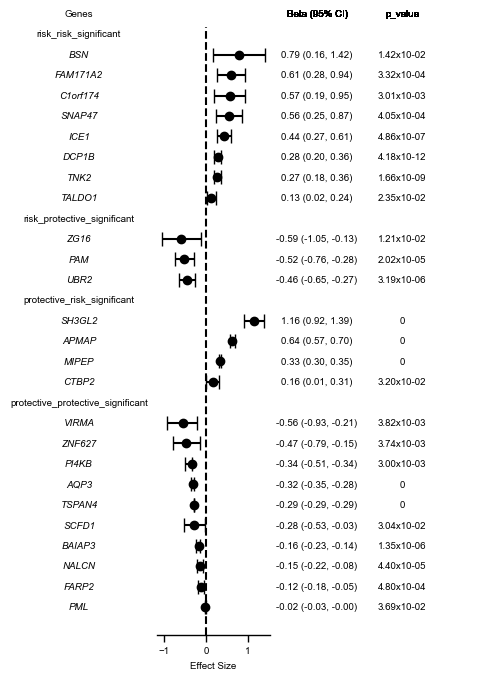

In [19]:
f = create_forestplot(
    plot_pgs_df, plot_pgs_df.sort_values(["category", "beta"]).gene.unique(), ["protective_protective_significant", "protective_risk_significant", "risk_protective_significant", "risk_risk_significant"][::-1],
    labels_col="gene", category_col="category", effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value"], sort_col="abs_beta"
)

In [20]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [21]:
save_pdf("../data/pgs_interaction/monogenic_pgs_int_meta_v2.pdf", f)